# Agrupamiento con K-medias

In [1]:
# Paquetes necesarios
#import requests
import pandas as pd
import os
#import wordmesh
import sys
#from wordmesh import Wordmesh

# Packages for text preprocessing
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams
from nltk import bigrams
import itertools
import collections

#import seaborn as sns
import pickle
import random
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import nltk
import networkx as nx

In [2]:
def remove_sw(words,sw_list):
    return [word for word in words if word not in sw_list]

#scriptPath = 'C:\\Users\\User\\Desktop\\DS4A_workspace\\Final Project\\DS4A-Final_Project-Team_28\\Personal\\Camilo'
scriptPath = sys.path[0]


# Absolute working directory
# Necessary for relative call inside the next loops
#os.chdir(scriptPath + '/Last_conpes_pdfs')
os.chdir(scriptPath)

# Cargar títulos    
titles_clean = pickle.load( open( "titles.p", "rb" ) )
    
# Clean additional stopwords
with open(scriptPath+'\\additional_stopwords.txt', 'rb') as f:
    sw_additional = f.read().decode('utf-8').replace(u'\r', u'').split(u'\n')

titles_clustering = [' '.join(w for w in p.split() if w not in sw_additional) for p in titles_clean]            

# Geografía
df_geoCol = pd.read_csv(scriptPath+'\\additional_stopwords.txt',
                 delimiter = '\t',
                 header=None)

geo_names = df_geoCol[0].tolist()
geo_names = [' '.join(geo_names)]
geo_names = geo_names[0].lower().split()

titles_clustering_f = [' '.join(w for w in p.split() if w not in geo_names) for p in titles_clustering]

## Vectorizar

In [3]:
#corpus = clean_text.Text.copy()
corpus = titles_clustering_f.copy()
#corpus = titles_2_clean.copy()

vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(corpus)

#print(matrix)

a = matrix.todense()
print(a)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Matriz de similitud

In [4]:

from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(a)
dist_mat = np.asmatrix(dist)
dist_mat


matrix([[ 1.11022302e-16,  8.10846273e-01,  9.79591008e-01, ...,
          9.48577242e-01,  8.89986494e-01,  9.36400281e-01],
        [ 8.10846273e-01,  1.11022302e-16,  8.44649379e-01, ...,
          9.62496308e-01,  7.41541590e-01,  8.37430555e-01],
        [ 9.79591008e-01,  8.44649379e-01,  1.11022302e-16, ...,
          9.73408276e-01,  8.66577196e-01,  7.96441197e-01],
        ...,
        [ 9.48577242e-01,  9.62496308e-01,  9.73408276e-01, ...,
         -2.22044605e-16,  9.44791943e-01,  9.62913347e-01],
        [ 8.89986494e-01,  7.41541590e-01,  8.66577196e-01, ...,
          9.44791943e-01,  0.00000000e+00,  7.76400331e-01],
        [ 9.36400281e-01,  8.37430555e-01,  7.96441197e-01, ...,
          9.62913347e-01,  7.76400331e-01,  0.00000000e+00]])

## Análisis de Componentes Principales

<function matplotlib.pyplot.show(*args, **kw)>

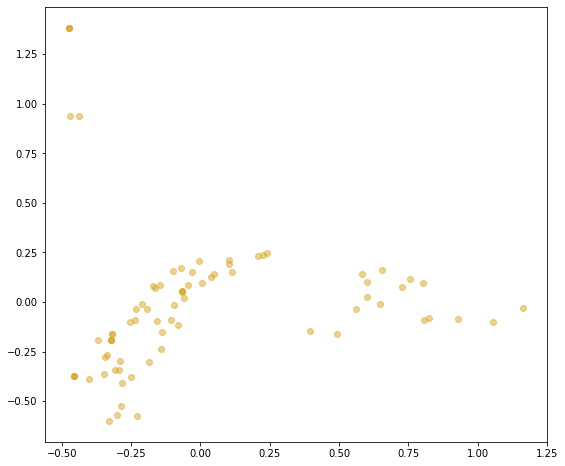

In [5]:
# Visualizar cluster con PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca_data = pca.fit_transform(dist_mat)

pca_all = pca.fit(dist_mat)
pca_all.explained_variance_ratio_
pca_all.explained_variance_ratio_.sum()

plt.figure(figsize=(9,8))
plt.scatter(pca_data[:,1], pca_data[:,2], c='goldenrod',alpha=0.5)
plt.show



## Escoger número de clusters

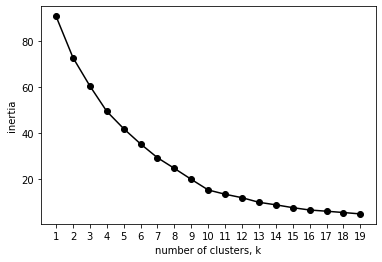

In [6]:
#-------------------------------------------------------------------------------
# Método del codo

# Guardar componentes en un dataframe
PCA_components = pd.DataFrame(pca_data)
PCA_components.iloc[:,9]

ks = range(1, 20)
inertias = []

for k in ks:
    # Modelo K-medias
    model = KMeans(n_jobs = -1, n_clusters=k, init='k-means++')
    
    # Ajustar modelo
    model.fit(PCA_components)
    
    # Resultado a la lista
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()



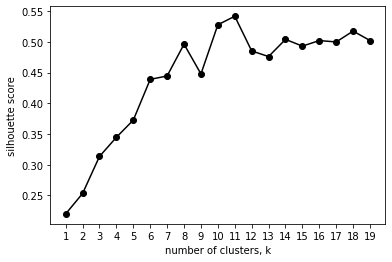

In [7]:
# Método de la Silueta
from sklearn.metrics import silhouette_score

random.seed(100)
sil = []
kmax = 20

#%matplotlib inline
#%matplotlib auto

for k in range(2, kmax+1):
  kmeans = KMeans(n_jobs = -1 ,n_clusters = k, init='k-means++',random_state=1).fit(PCA_components)
  labels = kmeans.labels_
  sil.append(silhouette_score(PCA_components, labels, metric = 'euclidean'))


plt.plot(ks,sil,  '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()



In [8]:
#### Número óptimo de clusters con distancia intra clusters - WCSS
from math import sqrt

def calculate_wcss(data):
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    
    return wcss

wcss = calculate_wcss(PCA_components)

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

optimal_number = optimal_number_of_clusters(wcss)

#--------------------------------------------------------------------------------
optimal_number


10

## K-medias

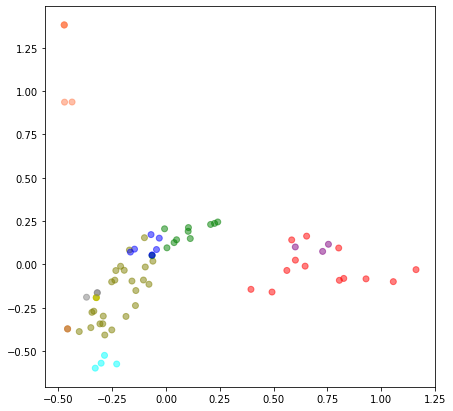

In [9]:
#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 10)

#Compute cluster centers and predict cluster indices
kmeans_object = kmeans.fit(PCA_components)
X_clustered = kmeans.fit_predict(PCA_components)

#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b', 3: 'y', 4: 'peru', 5:'coral', 6:'olive',7:'cyan',8:'purple',9:'grey'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(PCA_components.iloc[:,1],PCA_components.iloc[:,2], c= label_color, alpha=0.5) 
plt.show()


## Incrustación estocástica de vecinos embebidos (T-SNE) - UMAP

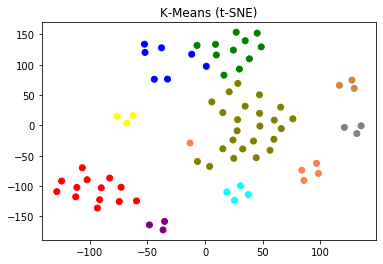

In [11]:

from sklearn.manifold import TSNE
X = TSNE(n_components=2, perplexity = 15).fit_transform( pca_data )

#plot graph
colors = np.array(['red','green','blue','yellow','peru','coral','olive','cyan','purple','grey'])
plt.scatter(X[:,0], X[:,1], c=colors[kmeans.labels_])
plt.title('K-Means (t-SNE)')
plt.show()    


## Extraer datos del cluster

In [12]:
# Extraer documentos de los clusters

documents_clustered = pd.DataFrame(titles_clustering_f, X_clustered, columns = ['titles'])
documents_clustered['cluster'] = documents_clustered.index
#documents_clustered = documents_clustered.reset_index()

documents_clustered = documents_clustered.sort_values(by=['cluster'])

documents_grouped = documents_clustered.groupby('cluster').agg(' '.join)
documents_grouped['cluster'] = np.arange(len(documents_grouped))


# Palabras más comunes por cluster
most_words = pd.DataFrame({"KeyWords" : documents_grouped["titles"].apply(lambda x: [k for k, v in Counter(x).most_common(50)])}) 

# Total de palabras
Counter(" ".join(documents_grouped["titles"]).split()).most_common(50)


words_per_cluster = []

for i in range(len(documents_grouped)):
    temp = Counter(documents_grouped['titles'][i].split()).most_common(20)
    words_per_cluster.append(temp)
    
words_per_cluster

[[('ministerio', 23),
  ('crédito', 17),
  ('público', 17),
  ('nación', 15),
  ('departamento', 15),
  ('concepto', 13),
  ('favorable', 13),
  ('equivalente', 13),
  ('monedas', 13),
  ('planeación', 13),
  ('hacienda', 13),
  ('contratar', 12),
  ('millones', 12),
  ('usd', 11),
  ('financiar', 10),
  ('externo', 9),
  ('banca', 8),
  ('multilateral', 8),
  ('suma', 7),
  ('empréstito', 6)],
 [('ministerio', 76),
  ('departamento', 20),
  ('desarrollo', 20),
  ('planeación', 14),
  ('territorio', 11),
  ('minas', 10),
  ('energía', 10),
  ('vivienda', 10),
  ('sostenible', 10),
  ('ciudad', 9),
  ('rural', 9),
  ('ambiente', 9),
  ('salud', 7),
  ('social', 7),
  ('comercio', 7),
  ('industria', 7),
  ('turismo', 7),
  ('educación', 7),
  ('administrativo', 7),
  ('unidad', 7)],
 [('ministerio', 17),
  ('desarrollo', 14),
  ('departamento', 13),
  ('rural', 11),
  ('tierras', 8),
  ('planeación', 7),
  ('agricultura', 6),
  ('administrativo', 6),
  ('unidad', 6),
  ('agencia', 6),
 

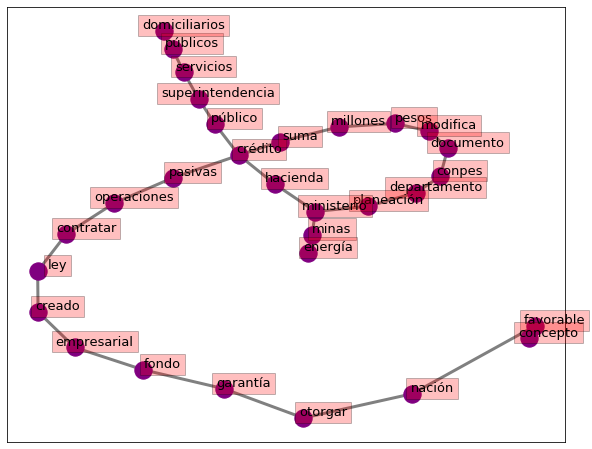

In [16]:
# Knowledge graphs

tokens = []

for i in range(len(documents_grouped)):
    temp = nltk.tokenize.word_tokenize(documents_grouped['titles'][i])
    tokens.append(temp)

# Red de bigramas
    
def bigram_network(cluster):
    ngram = list(ngrams(cluster, 2))
    ngram_frequency = nltk.FreqDist(ngram)
#ngram_frequency.plot(30,cumulative=False)

    ngram_frequency = dict(ngram_frequency.copy())
    ngram_table = pd.DataFrame.from_dict(ngram_frequency, orient='Index', columns = ['frequency'])
    ngram_table.reset_index(level=0, inplace=True)
    # Order the table
    ngram_table = ngram_table.sort_values(by=['frequency'], ascending = False)

    terms_bigram = [list(bigrams(cluster))]
    bigrams_l = list(ngrams(cluster, 2))
    bigrams_l = list(itertools.chain(*terms_bigram))
    
    bigram_counts = collections.Counter(bigrams_l)
    bigram_counts_graph = bigram_counts.most_common(30)
    bigram_df = pd.DataFrame(bigram_counts_graph).reset_index()

    #bigram_df = pd.DataFrame.from_dict(bigram_counts_graph, orient='index').reset_index()
    bigram_df.columns = ['index','bigram','count']
    #bigram_df = pd.DataFrame(bigram_df, columns = ['bigram', 'count'])


    # ATTEMPT
    # Create dictionary of bigrams and their counts

    d = bigram_df.set_index('bigram').T.to_dict('records')

    # Create network plot 
    G = nx.Graph()

    type(ngram_frequency)

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    #G.add_node("china", weight=100)

    fig, ax = plt.subplots(figsize=(10, 8))

    pos = nx.spring_layout(G, k=1)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=16,
                     width=3,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)

    # Default values

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.06, value[1]+.01
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=13)
    
    plt.show()
    
#%matplotlib auto
%matplotlib inline
    
bigram_network(tokens[8])


